In [1]:
import os
import sys
# Import modules from base directory
sys.path.insert(0, os.getcwd())

import json
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as trfms
from torch.utils.data import Dataset

8144


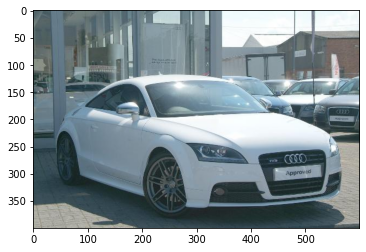

In [2]:
data = torchvision.datasets.StanfordCars(root="./data")

index = 0
image = trfms.ToTensor()(data[index][0])
plt.imshow(image.permute(1, 2, 0))
print(len(data))

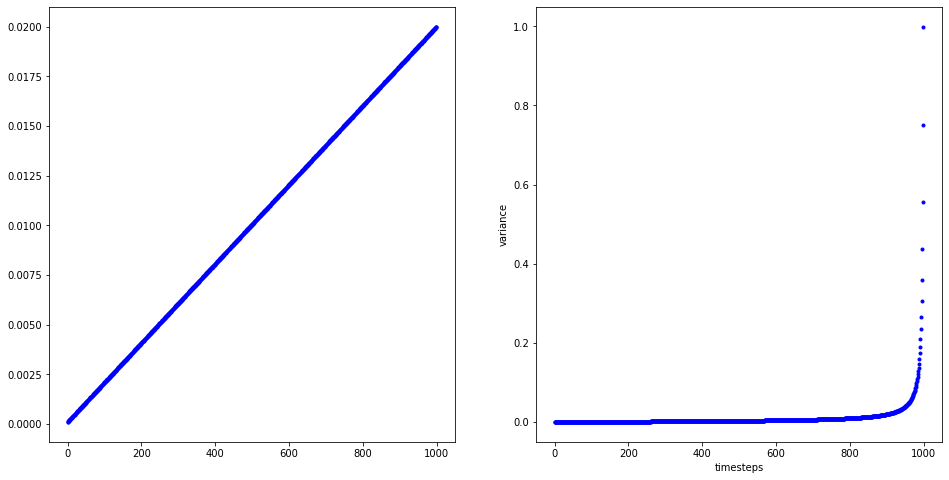

In [3]:
from models.variance_scheduler import linear_beta_schedule, cosine_beta_schedule

num = 1000
timesteps = torch.arange(num)

# find betas
vars = linear_beta_schedule(num)
cos_vars = cosine_beta_schedule(num)

fig, axs = plt.subplots(1, 2, figsize=(16, 8))
plt.xlabel(r'timesteps') 
plt.ylabel(r'variance')
axs[0].plot(timesteps, vars, 'b.')
axs[1].plot(timesteps, cos_vars, 'b.')
# plt.title(r'Scatter Plot of $s_{ij}^*$ vs $s_{ij,T}$')
plt.show() 

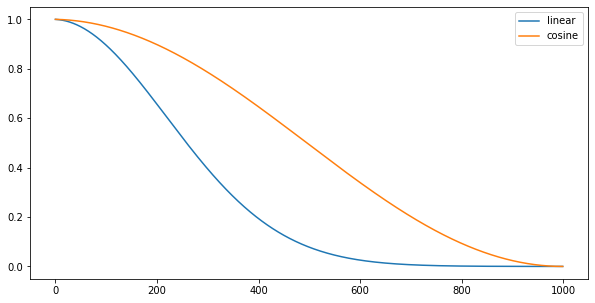

In [4]:
# get cumprods (alpha overline)
cumprods = torch.cumprod(1 - vars, dim=0)
cos_cumprods = torch.cumprod(1 - cos_vars, dim=0)

plt.figure(figsize=(10,5)) 
plt.plot(timesteps, cumprods, label = "linear")
plt.plot(timesteps, cos_cumprods,label = "cosine")
plt.legend()
plt.show()

In [5]:
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

from tools.predictor import pred

initialize(version_base=None, config_path="./config", job_name="test_app")
cfg = compose(config_name="test_defaults")

In [6]:
# build model
pretrained = cfg.pretrained
task = hydra.utils.instantiate(cfg.tasks, cfg).load_from_checkpoint(
    pretrained, dataset=cfg.dataset, map_location=None
)

sampling loop time step: 100%|██████████| 300/300 [04:17<00:00,  1.17it/s]


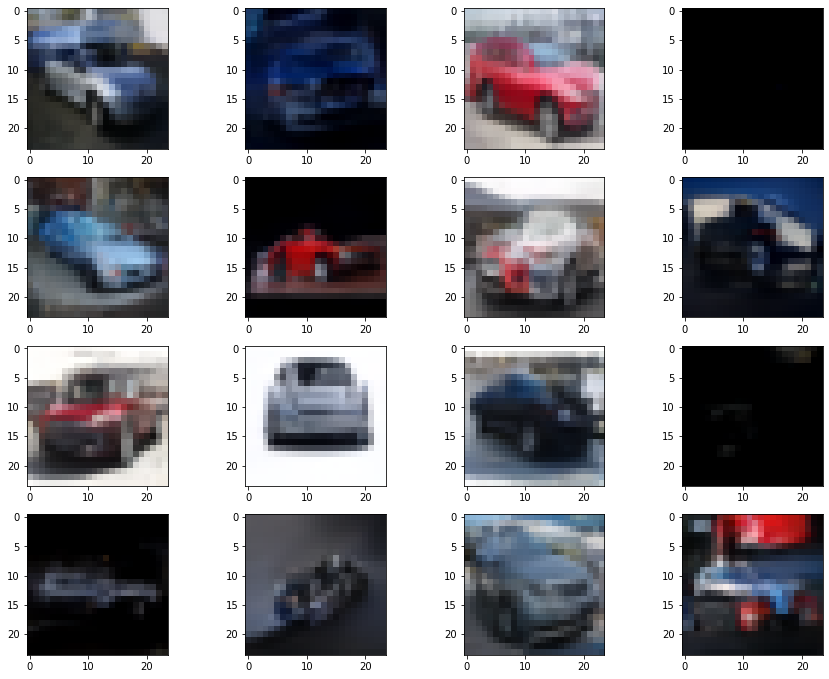

In [7]:
from utils.visualize import plot_sample_image

imgs = task.model.sample()
plot_sample_image(imgs[-1])

MovieWriter ffmpeg unavailable; using Pillow instead.


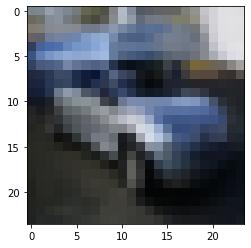

In [8]:
from utils.visualize import plot_sample_gif

plot_sample_gif(imgs)

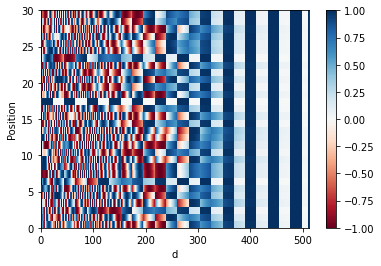

In [12]:
import math
dim = 512
x = torch.randint(low=0, high=300, size=(30,))

half_dim = dim // 2
emb = math.log(10000) / (half_dim - 1)
emb = torch.exp(torch.arange(half_dim) * -emb)
emb = x[:, None] * emb[None, :]
# y = torch.cat((emb.sin(), emb.cos()), dim=-1))
y = torch.zeros(30, dim)
y[:, 0::2] = emb.sin()
y[:, 1::2] = emb.cos()

plt.pcolormesh(y, cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, dim))
plt.ylabel('Position')
plt.colorbar()
plt.show()

torch.Size([1, 50, 512])


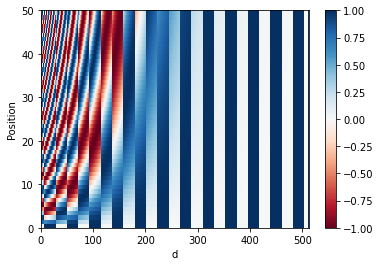

In [10]:

def get_angles(pos, k, d):
    """
    Get the angles for the positional encoding
    
    Arguments:
        pos -- Column vector containing the positions [[0], [1], ...,[N-1]]
        k --   Row vector containing the dimension span [[0, 1, 2, ..., d-1]]
        d(integer) -- Encoding size
    
    Returns:
        angles -- (pos, d) numpy array 
    """
    
    # START CODE HERE
    # Get i from dimension span k
    i = k//2
    # Calculate the angles using pos, i and d
    angles = pos/(10000**(2*i/d))
    # END CODE HERE
    
    return angles

def positional_encoding(positions, d):
    """
    Precomputes a matrix with all the positional encodings 
    
    Arguments:
        positions (int) -- Maximum number of positions to be encoded 
        d (int) -- Encoding size 
    
    Returns:
        pos_encoding -- (1, position, d_model) A matrix with the positional encodings
    """
    # START CODE HERE
    # initialize a matrix angle_rads of all the angles 
    angle_rads = get_angles(np.arange(positions)[:,np.newaxis],
                            np.arange(d)[np.newaxis,:],
                            d)
  
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    # END CODE HERE
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return torch.tensor(pos_encoding, dtype=torch.float32)

pos_encoding = positional_encoding(50, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()